# SBP(수축기혈압) 

### X변수(기본)
- sex : 1(남자), 2(여자)
- age : 20세 부터 5세 단위
- ht : 5cm단위
- wt : 5kg 단위
- waist : 허리둘레 cm
- bmi 
- absi : 체형지수 => 허리둘레 / (BMI * 2/3) * (ht * 1/2)
- smoking : 1(피우지 않음), 2(피웠다끊음), 3(피우고있음)
- alcohol : 0(마시지않음), 1(마심)

In [30]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 1. 데이터 불러오기

In [31]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [32]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','수축기혈압']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','sbp']

## 2. 데이터 전처리

### 1) 결측값 제거

In [33]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  int64  
 1   age      999089 non-null  int64  
 2   ht       999089 non-null  int64  
 3   wt       999089 non-null  int64  
 4   waist    999089 non-null  float64
 5   smoking  999089 non-null  float64
 6   alcohol  999089 non-null  object 
 7   sbp      999089 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


### 2) bmi column 생성

In [34]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)

### 3) absi columns 생성

- 허리둘레 / (BMI * 2/3) * (ht * 1/2)

In [35]:
df['absi'] = (df['waist']*0.393701) /((df['bmi']**0.6666) * ((df['ht']/100)**0.5))
df = df.round(decimals = 2)

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,sbp,bmi,absi
0,1,8,170,75,90.0,1.0,Y,120.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,130.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,120.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,145.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,138.0,22.04,3.12


### 3) alcohol : str -> float형으로 변환

In [36]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  int64  
 1   age      999089 non-null  int64  
 2   ht       999089 non-null  int64  
 3   wt       999089 non-null  int64  
 4   waist    999089 non-null  float64
 5   smoking  999089 non-null  float64
 6   alcohol  999089 non-null  float64
 7   sbp      999089 non-null  float64
 8   bmi      999089 non-null  float64
 9   absi     999089 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


### 4) 이상값 제거

- IQR = Q3 - Q1 
- Q1 -3 * IQR => lower
- Q3 + 3 * IQR => upper 로 설정
- lower보다 작거나 upper보다 큰 값을 이상값으로 간주하고 제거

- 변수마다 lower, upper 값을 확인하고 제거하는 과정을 거치면 다른 변수 lower/upper값에 영향을 줄 수 있음
- 따라서, 변수 각각의 lower, upper 값을 미리 모두 확인 후 각 값에 맞춰 범위 외의 값을 제거해줌.

#### (1) lower / upper 값 구하기

In [38]:
columns = ['bmi','waist', 'absi', 'sbp']

for column in columns:
    
    print('=======', column, '=======')
    
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')
    


======= bmi =======
lower : 8.070000000000004
upper : 39.36 

======= waist =======
lower : 32.999999999999986
upper : 128.9 

======= absi =======
lower : 2.119999999999999
upper : 3.940000000000001 

======= sbp =======
lower : 55.0
upper : 188.0 



#### (2) 이상값 제거

In [39]:
# bmi
#df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55.0)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# sbp
#df.drop(df.loc[(df['sbp']>188.0)|(df['sbp']<55.0)].index, inplace = True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   ht       998149 non-null  int64  
 3   wt       998149 non-null  int64  
 4   waist    998149 non-null  float64
 5   smoking  998149 non-null  float64
 6   alcohol  998149 non-null  float64
 7   sbp      998149 non-null  float64
 8   bmi      998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


## 2. Scaling

- 표준화(Standardization)
- 정규화(Normalization)

### 1) 표준화 : df_s

In [41]:
scaler2 = StandardScaler()

x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])
x_absi = scaler2.fit_transform(df[['absi']])

df_s = df[['sex','age','ht','wt','smoking','alcohol','sbp']]

df_s['bmi'] = x_bmi
df_s['waist'] = x_waist
df_s['absi'] = x_absi

print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   ht       998149 non-null  int64  
 3   wt       998149 non-null  int64  
 4   smoking  998149 non-null  float64
 5   alcohol  998149 non-null  float64
 6   sbp      998149 non-null  float64
 7   bmi      998149 non-null  float64
 8   waist    998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB
None


,sex,age,ht,wt,smoking,alcohol,sbp,bmi,waist,absi
0,1,8,170,75,1.0,1.0,120.0,0.578404,0.920798,0.339875
1,1,7,180,80,3.0,0.0,130.0,0.219742,0.816384,0.239239
2,1,9,165,75,1.0,0.0,120.0,1.033847,1.025212,0.138603
3,1,11,175,80,1.0,0.0,145.0,0.626795,1.025212,0.239239
4,1,11,165,60,1.0,0.0,138.0,-0.534585,-0.123341,0.440511


### 2) 정규화 : df_n

In [42]:
scaler1 = MinMaxScaler()

x_bmi = scaler1.fit_transform(df[['bmi']])
x_waist = scaler1.fit_transform(df[['waist']])
x_absi = scaler1.fit_transform(df[['absi']])

df_n = df[['sex','age','ht','wt','smoking','alcohol', 'sbp']]

df_n['bmi'] = x_bmi
df_n['waist'] = x_waist
df_n['absi'] = x_absi

print(df_n.info())
df_n.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   ht       998149 non-null  int64  
 3   wt       998149 non-null  int64  
 4   smoking  998149 non-null  float64
 5   alcohol  998149 non-null  float64
 6   sbp      998149 non-null  float64
 7   bmi      998149 non-null  float64
 8   waist    998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB
None


,sex,age,ht,wt,smoking,alcohol,sbp,bmi,waist,absi
0,1,8,170,75,1.0,1.0,120.0,0.405178,0.479452,0.538462
1,1,7,180,80,3.0,0.0,130.0,0.367249,0.465753,0.527473
2,1,9,165,75,1.0,0.0,120.0,0.453341,0.493151,0.516484
3,1,11,175,80,1.0,0.0,145.0,0.410295,0.493151,0.527473
4,1,11,165,60,1.0,0.0,138.0,0.287477,0.342466,0.549451


# 3. Modeling 

## 1-1) Linear Regression_표준화

In [43]:
## 1. split

X = df_s[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_s['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [44]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.180674484424266


## 1-2) Linear Regression_정규화

In [45]:
## 1. split

X = df_n[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df_n['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [46]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.180674484424268


## 1-3) Linear Regression_이상치제거

In [47]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [48]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.180674484424266


<AxesSubplot:>

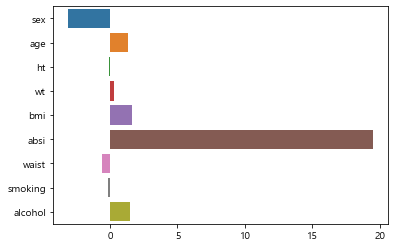

In [49]:
coef = pd.Series(RA.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

## 2-1) ( Polynomial ) Linear Regression2차_이상치제거

In [50]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [51]:
## 2. polynomialFeatures(degree=2)

poly_train = PolynomialFeatures(degree=2).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=2).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.102767150411161


## 2-2) ( Polynomial ) Linear Regression3차_이상치제거

In [52]:
## 2. polynomialFeatures(degree=3)

poly_train = PolynomialFeatures(degree=3).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=3).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.084525157753681


### 4차 다항회귀분석을 수행했을 때는 오히려 rmse가 15로 증가
### - Overfitting으로 인해 오히려 성능저하로 판단. 

### 정규화와 표준화는 polynomial linear regression 에서는 차이가 없음(rmse값 소수 4째자리에서 차이발생)

## 3-1) 규제선형모델 Ridge Regression_원본

- 표준화, 정규화 등 scaling 처리한 데이터와 원본 데이터의 결과 성능이 차이가 없음

In [53]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [54]:
## 2. model define

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas :
    
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0  =====
rmse :  13.180674484424266
===== alpha =  0.1  =====
rmse :  13.180674874044968
===== alpha =  1  =====
rmse :  13.180678415231544
===== alpha =  10  =====
rmse :  13.18071708367421
===== alpha =  100  =====
rmse :  13.181306419795952


## 3-2) Lasso Regression_원본

- Ridge와 마찬가지로 x를 scaling한 데이터와 모델 성능에 차이가 없음

In [55]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [56]:
## 2. model define

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas :
    
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_hat = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0  =====
rmse :  13.18067885374654
===== alpha =  0.1  =====
rmse :  13.197353574862852
===== alpha =  1  =====
rmse :  13.259603353267048
===== alpha =  10  =====
rmse :  13.73077351728624
===== alpha =  100  =====
rmse :  14.565788822551077


## 3-3) ElasticNet Regression _원본

In [57]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698704, 9), (299445, 9), (698704,), (299445,))

In [58]:
## 2. model define

alphas = [0.07, 0.1, 0.3, 0.5, 1]

for alpha in alphas :
    
    elastic = ElasticNet(alpha = alpha, l1_ratio=0.7)
    elastic.fit(X_train, y_train)
    y_hat = elastic.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0.07  =====
rmse :  13.195947786689123
===== alpha =  0.1  =====
rmse :  13.19913388594109
===== alpha =  0.3  =====
rmse :  13.226587732915425
===== alpha =  0.5  =====
rmse :  13.253790044440244
===== alpha =  1  =====
rmse :  13.260057365408969


## 모델성능 : 3차 Linear Regression > 2차 Linear Regression > LinearRegression = Ridge = Lasso = ElasticNet

- Linear Regression 성능은 크게 개선되는 모델 없이 대략 rmse가 13~13.1을 보임. 

- 과적합 우려가 있어서 규제선형모델(ridge, lasso, elasticNet)을 정의해보았는데 오히려 규제를 할수록 성능이 아주조금씩 저하됨

- linear regression에서는 과적합 문제는 이슈가 되지 않는다고 판단. 